<a href="https://colab.research.google.com/github/shashankcuber/mRNA_Vacc_Stabilization/blob/main/mRNA_vaccine_stabilizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount dataset and rna tools from Drive

In [1]:
from google.colab import drive
#make sure you give the necessary authorization for colab to access your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing RNA tools

Fix these changes if you download the contrafold source code directly from http://contra.stanford.edu/contrafold/download.html


1.   LBFGS.ipp :  At line 110 write this->DoLineSearch
2.   Utilities.cpp:  Add #include"climits" for ULONG used in this file



In [ ]:
!cd drive/MyDrive/Bio_informatics_Project/; sh install.sh -Uq

# Setting up the arnie conf file and environment variable

In [ ]:
import os
os.environ["DATAPATH"] = "/content/RNAstructure/data_tables"
os.environ["ARNIEFILE"] = "/content/arnie.conf"
!cd drive/MyDrive/Bio_informatics_Project/; sh make_arnie_conf.sh

# Importing Libraries For Test Data

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
from arnie.bpps import bpps
import arnie.utils as utils
from arnie.mea.mea import MEA

# Test data replication using rna tools

In [5]:
class PrepareTestDataset:
  def __init__(self, rna_tool, path):
    self.package = rna_tool
    self.path = path
    self.df = pd.read_csv(path)


  def _predict_structure(self, id, rna_sequence):
    base_pairing_mat = bpps(rna_sequence, package = self.package)
    secondary_struct = MEA(base_pairing_mat)
    return id, rna_sequence, secondary_struct.structure, self.package
  
  def make_dataset(self):
    temp_df = self.df[['id','sequence']]
    
    dataset = []

    for j,(id,seq) in enumerate(tqdm(temp_df[['id', 'sequence']].values)):
      data = self._predict_structure(id, seq)
      dataset.append(data)

    df = pd.DataFrame(dataset, columns = ['id', 'sequence', 'structure','package'])
    df['seq_length'] = df['id'].map(self.df.drop_duplicates().set_index('id')['seq_length'])
    df['seq_scored'] = df['id'].map(self.df.drop_duplicates().set_index('id')['seq_scored'])
    return df

In [6]:
"""
UNCOMMENT THE COMMENTED CODE AND COMMENT THE UNCOMMENTED CODE FOR PRODUCING EACH DATASET
"""

# open_vaccine_test_data_path = '/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/test_data.csv'

"""
VIENNA PACKAGE ON TEST DATA
"""

#vienna_2
# vienna = PrepareTestDataset('vienna_2', open_vaccine_test_data_path)
# vienna_df = vienna.make_dataset()
# vienna_df.head()
# vienna_df.to_csv("/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/vienna_df.csv")

vienna_df = pd.read_csv("/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/vienna_df.csv")
vienna_df = vienna_df[['id', 'sequence', 'structure', 'package', 'seq_length',
       'seq_scored']]

"""
CONTRAFOLD PACKAGE ON TEST DATA
"""
#contrafold_2
# contrafold = PrepareTestDataset('contrafold_2', open_vaccine_test_data_path)
# contrafold_df = contrafold.make_dataset()
# contrafold_df.head()
# contrafold_df.to_csv("/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/contrafold_df.csv")

contrafold_df = pd.read_csv("/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/contrafold_df.csv")
contrafold_df = contrafold_df[['id', 'sequence', 'structure', 'package', 'seq_length',
       'seq_scored']]

"""
RNASTRUCTURE PACKAGE ON TEST DATA
"""
#rnastructure
# rnastructure = PrepareTestDataset('rnastructure', open_vaccine_test_data_path)
# rnastructure_df = rnastructure.make_dataset()
# rnastructure_df.head()
# rnastructure_df.to_csv("/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/rnastructure_df.csv")

rnastructure_df = pd.read_csv("/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/rnastructure_df.csv")
rnastructure_df = rnastructure_df[['id', 'sequence', 'structure', 'package', 'seq_length',
       'seq_scored']]

# Importing Libraries and setting up wandb for logging losses and model params
Note: Use your own WB_API_KEY

In [7]:
"""
Importing the necessary libraries
"""
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.modules.loss import MSELoss
from sklearn.model_selection import train_test_split, KFold
torch.backends.cudnn.deterministic = True

import random

# To ensure the random function generates the same random values on different runs
random.seed(hash("setting random seeds") % 2023)
np.random.seed(hash("improves reproducibility") % 2023)
torch.manual_seed(hash("by removing stochasticity") % 2023)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2023)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
token_int_dict = {
        '(' : 0,
        ')' : 1,
        '.' : 2,
        'A' : 3,
        'G' : 4,
        'C' : 5,
        'U' : 6,
    }
WB_API_KEY = "WANDB API KEY"

cuda:0


In [ ]:
"""
Insatalling Weights and Biases wandb to track the Model evaluation
and login to wandb
"""
!pip install wandb -Uq
import wandb
wandb.login(key = WB_API_KEY) 

# Processing and preparing training dataset

In [11]:
"""
LOADING THE TRAIN DATA
"""
open_vaccine_train_data_path = '/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/train.json'
train_df = pd.read_json(open_vaccine_train_data_path, lines=True)
train_df = train_df.drop(columns=['index'])

In [13]:
"""
Making x_train and y_train tensors
"""
class DataPreprocessing:
  def __init__(self, data, device, token_int_dict, feature_columns = ["sequence", "structure"], 
               train_data = True, labels = None):
    self.df = data
    self.feature_columns = feature_columns
    self.labels = labels
    self.token_int_dict = token_int_dict
    self.device = device
    self.is_train = train_data

  def num_missing_val(self):
    return self.df.isnull().values.sum()

  def sn_filtering(self):
    self.df = self.df[self.df.SN_filter == 1]

  def tokenize_sequence(self,sequence):
    tokenized_sequence = []
    for char in sequence:
      tokenized_sequence.append(self.token_int_dict[char])
    return tokenized_sequence

  def convert_df_to_array(self, df):
    return np.transpose(np.array(df.values.tolist()), (0,2,1))

  def process_data(self):
    #check if any missing values
    if self.num_missing_val() > 0 and self.is_train:
      self.sn_filtering()
      print(f"Number of missing values in the dataset are:{self.num_missing_val()}")
    elif self.is_train:
      self.sn_filtering()
      print("No Missing Values")
    
    feature_df = self.df[self.feature_columns].applymap(lambda sequence: self.tokenize_sequence(sequence))
    feature_tensor =  torch.tensor(self.convert_df_to_array(feature_df)).to(self.device)

    if self.is_train:
      label_tensor = torch.tensor(self.convert_df_to_array(self.df[self.labels])).float().to(self.device)
      return feature_tensor, label_tensor
  
    return feature_tensor

labels = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
train_process = DataPreprocessing(train_df, device, token_int_dict,  labels = labels)
x_train, y_train = train_process.process_data()

print(x_train.shape)
print(y_train.shape)

No Missing Values
torch.Size([1589, 107, 2])
torch.Size([1589, 68, 5])


# Preprocessing and preparing Test Dataset of Vienna_2, Contrafold and Rnastructure

In [14]:
"""
Packages public and private loader
"""
def data_loader_test_package(df):
  df_pub = df.query("seq_length == 107").copy()
  df_priv = df.query("seq_length == 130").copy()

  process_pub = DataPreprocessing(df_pub, device, token_int_dict, train_data = False)
  process_priv = DataPreprocessing(df_priv, device, token_int_dict, train_data = False)

  tensor_pub = process_pub.process_data()
  tensor_priv = process_priv.process_data()

  # print(tensor_pub.shape)
  # print(tensor_priv.shape)
  loader_pub = DataLoader(TensorDataset(tensor_pub), shuffle=False, batch_size=64)
  loader_priv = DataLoader(TensorDataset(tensor_priv), shuffle=False, batch_size=64)
  return df_pub, df_priv, loader_pub, loader_priv


vienna_public_df, vienna_private_df, vienna_public_loader, vienna_private_loader = data_loader_test_package(vienna_df)
contrafold_public_df, contrafold_private_df, contrafold_public_loader, contrafold_private_loader = data_loader_test_package(contrafold_df)
rnastructure_public_df, rnastructure_private_df, rnastructure_public_loader, rnastructure_private_loader = data_loader_test_package(rnastructure_df)

# MCRMSE LOSS
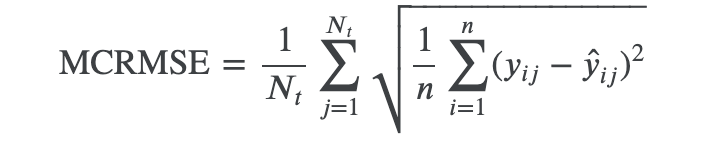

In [13]:
class MeanColumnwiseRMSE(nn.Module):
  def __init__(self, N_t):
    super().__init__()
    self.loss = nn.MSELoss()
    self.nt = N_t
  
  def forward(self, predicted , actual):
    total_loss = 0

    for j in range(self.nt):
        total_loss += torch.sqrt(self.loss(predicted[:, :, j], actual[:, :, j]))

    total_loss /= self.nt
    return total_loss

# bi-GRU Model

In [15]:
class bi_GRU(nn.Module):
  def __init__(self, config, public_data = False, private_data = False):
    super(bi_GRU, self).__init__()
    if(public_data):
      self.prediction_len = 68
      self.squence_len = 107
    elif private_data:
      self.prediction_len = 91
      self.squence_len = 130

    self.token_int_len = len(token_int_dict)
    self.embedding_layer = nn.Embedding(num_embeddings = self.token_int_len, embedding_dim = config.embedding_dim)
    self.bi_gru = nn.GRU(
        input_size = config.gru_input_size,
        hidden_size = config.gru_hidden_size,
        num_layers = config.gru_num_layers,
        batch_first = True,
        dropout = config.gru_dropout_rate,
        bidirectional = True)
    self.l1 = nn.Linear(config.gru_hidden_size * 2, len(labels))
  
  def reshape_embedding(self, embedding):
      x , y , z = embedding.shape[1] , embedding.shape[2], embedding.shape[3]
      return torch.reshape(embedding, (-1, x, y * z))
      
  def forward(self, sequence):
    embedding = self.embedding_layer(sequence)
    embed_reshape = self.reshape_embedding(embedding)
    output,h_n = self.bi_gru(embed_reshape)
    slice_output = output[:, : self.prediction_len, :]
    final_output = self.l1(slice_output)
    return final_output

# Train Step

In [18]:
class Train:
  def __init__(self, x_train, y_train, model, loss_criterion, optimizer, training=True):
    self.x_train = x_train
    self.labels = y_train
    self.model = model
    self.loss_criterion = loss_criterion
    self.optimizer = optimizer
    self.training = training

  def train_step(self):
    wandb.watch(self.model, self.loss_criterion, log="all")
    # forward propogation
    self.model.train(self.training)
    output = self.model(self.x_train)
    loss = self.loss_criterion.forward(output, self.labels)
    #backward propogation
    if self.training:
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    return loss.item()

# Defing the training configuration and wandb initialisation

In [ ]:
train_config = dict(
    k_fold=3,
    epochs=80,
    batch_size=64,
    learning_rate=0.01,
    embedding_dim=200,
    gru_input_size=200 * 2,
    gru_hidden_size=128,
    gru_num_layers=3,
    gru_dropout_rate=0.5)

run = wandb.init(project="mRNA-Stabilization-test-3", config = train_config)
train_config = wandb.config

#Training bi-GRU Model

In [26]:
def train(x_train, y_train, train_config):
  x_train = x_train.to(device)
  y_train = y_train.to(device)

  train_val_losses = []

  criterion = MeanColumnwiseRMSE(len(labels))
  kcv = KFold(train_config.k_fold, shuffle=True, random_state=2023)

  for k, (train_index, val_index) in enumerate(kcv.split(x_train)):
      train_dataset = TensorDataset(x_train[train_index], y_train[train_index])
      val_dataset = TensorDataset(x_train[val_index], y_train[val_index])

      train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_config.batch_size)
      val_loader = DataLoader(val_dataset, shuffle=False, batch_size=train_config.batch_size)

      bi_gru = bi_GRU(train_config, public_data=True).to(device)
      optimizer = optim.Adam(bi_gru.parameters(), lr=train_config.learning_rate)

      train_losses_epoch = []
      val_losses_epoch = []
      run = wandb.init(reinit = True, project="mRNA-Stabilization-test-2", config = train_config)

      for epoch in tqdm(range(train_config.epochs)):
          train_losses_batch = []
          val_losses_batch = []

          for (batch_X, batch_Y) in train_loader:
              training = Train(batch_X.to(device), batch_Y.to(device), bi_gru, criterion, optimizer, training=True)
              train_loss = training.train_step()
              train_losses_batch.append(train_loss)
          train_losses_epoch.append(np.mean(train_losses_batch))

          for (batch_X, batch_Y) in val_loader:
              validation = Train(batch_X.to(device), batch_Y.to(device), bi_gru, criterion, optimizer, training=False)
              val_loss = validation.train_step()
              val_losses_batch.append(val_loss)
          val_losses_epoch.append(np.mean(val_losses_batch))

          wandb.log({
              "epoch": epoch, 
              "train_loss": np.mean(train_losses_batch), 
              "val_loss": np.mean(val_losses_batch)
              })
          
          print(f" At EPOCH = {epoch} , TRAINING LOSS = {np.mean(train_losses_batch)} , VALIDATION LOSS = {np.mean(train_losses_batch)}")
      
      run.finish()
      train_val_losses.append({'train_loss': train_losses_epoch, 'val_loss': val_losses_epoch})

  torch.save(bi_gru.state_dict(), "/content/drive/MyDrive/Bio_informatics_Project/bi-gru.pt")
  del bi_gru
  return train_val_losses

train_val_losses = train(x_train, y_train, train_config)

  0%|          | 0/80 [00:00<?, ?it/s]

 At EPOCH = 0 , TRAINING LOSS = 0.7473378058742074 , VALIDATION LOSS = 0.7473378058742074
 At EPOCH = 1 , TRAINING LOSS = 0.4198051936486188 , VALIDATION LOSS = 0.4198051936486188
 At EPOCH = 2 , TRAINING LOSS = 0.40015025699839873 , VALIDATION LOSS = 0.40015025699839873
 At EPOCH = 3 , TRAINING LOSS = 0.39034221628132987 , VALIDATION LOSS = 0.39034221628132987
 At EPOCH = 4 , TRAINING LOSS = 0.38371652364730835 , VALIDATION LOSS = 0.38371652364730835
 At EPOCH = 5 , TRAINING LOSS = 0.37989265953793244 , VALIDATION LOSS = 0.37989265953793244
 At EPOCH = 6 , TRAINING LOSS = 0.374057543628356 , VALIDATION LOSS = 0.374057543628356
 At EPOCH = 7 , TRAINING LOSS = 0.36195987988920775 , VALIDATION LOSS = 0.36195987988920775
 At EPOCH = 8 , TRAINING LOSS = 0.35985736285938935 , VALIDATION LOSS = 0.35985736285938935
 At EPOCH = 9 , TRAINING LOSS = 0.35665620775783763 , VALIDATION LOSS = 0.35665620775783763
 At EPOCH = 10 , TRAINING LOSS = 0.3548523941460778 , VALIDATION LOSS = 0.35485239414607

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▄▄▃▂▄▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▁▁▃▁▁▁▁
epoch,79
train_loss,0.32245
val_loss,0.31553


  0%|          | 0/80 [00:00<?, ?it/s]

 At EPOCH = 0 , TRAINING LOSS = 0.7112514061086318 , VALIDATION LOSS = 0.7112514061086318
 At EPOCH = 1 , TRAINING LOSS = 0.4154486515942742 , VALIDATION LOSS = 0.4154486515942742
 At EPOCH = 2 , TRAINING LOSS = 0.3986782449133256 , VALIDATION LOSS = 0.3986782449133256
 At EPOCH = 3 , TRAINING LOSS = 0.3898797368302065 , VALIDATION LOSS = 0.3898797368302065
 At EPOCH = 4 , TRAINING LOSS = 0.376818201121162 , VALIDATION LOSS = 0.376818201121162
 At EPOCH = 5 , TRAINING LOSS = 0.36765410619623523 , VALIDATION LOSS = 0.36765410619623523
 At EPOCH = 6 , TRAINING LOSS = 0.3742871810408199 , VALIDATION LOSS = 0.3742871810408199
 At EPOCH = 7 , TRAINING LOSS = 0.3692241591565749 , VALIDATION LOSS = 0.3692241591565749
 At EPOCH = 8 , TRAINING LOSS = 0.3625573358115028 , VALIDATION LOSS = 0.3625573358115028
 At EPOCH = 9 , TRAINING LOSS = 0.36432918906211853 , VALIDATION LOSS = 0.36432918906211853
 At EPOCH = 10 , TRAINING LOSS = 0.359875640448402 , VALIDATION LOSS = 0.359875640448402
 At EPOCH

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▄▃▃▅▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁
epoch,79
train_loss,0.32703
val_loss,0.31239


  0%|          | 0/80 [00:00<?, ?it/s]

 At EPOCH = 0 , TRAINING LOSS = 0.6783293801195481 , VALIDATION LOSS = 0.6783293801195481
 At EPOCH = 1 , TRAINING LOSS = 0.41795476219233346 , VALIDATION LOSS = 0.41795476219233346
 At EPOCH = 2 , TRAINING LOSS = 0.402791571967742 , VALIDATION LOSS = 0.402791571967742
 At EPOCH = 3 , TRAINING LOSS = 0.39810073551009684 , VALIDATION LOSS = 0.39810073551009684
 At EPOCH = 4 , TRAINING LOSS = 0.3894672113306382 , VALIDATION LOSS = 0.3894672113306382
 At EPOCH = 5 , TRAINING LOSS = 0.3859315391849069 , VALIDATION LOSS = 0.3859315391849069
 At EPOCH = 6 , TRAINING LOSS = 0.38200225724893455 , VALIDATION LOSS = 0.38200225724893455
 At EPOCH = 7 , TRAINING LOSS = 0.38477877308340636 , VALIDATION LOSS = 0.38477877308340636
 At EPOCH = 8 , TRAINING LOSS = 0.38247724841622743 , VALIDATION LOSS = 0.38247724841622743
 At EPOCH = 9 , TRAINING LOSS = 0.38021191428689394 , VALIDATION LOSS = 0.38021191428689394
 At EPOCH = 10 , TRAINING LOSS = 0.37520625661401186 , VALIDATION LOSS = 0.375206256614011

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▆▅▄▅▄▃▃▃▃▂▃▂▃▂▂▂▂▂▃▂▂▁▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂
epoch,79
train_loss,0.35721
val_loss,0.33236


# Inference class for different packages
Note: Mean for each labels predicted over different sequence length is calculated and showed 

In [17]:
class DataFrameMeanLabelValues:
  def __init__(self, df, test_loader, model_path = "/content/drive/MyDrive/Bio_informatics_Project/bi-gru.pt",
               config=train_config, public=False, private=False):
    self.df = df
    self.config = config
    self.path = model_path
    self.is_public = public
    self.is_private = private
    self.x_test = test_loader

  def load_model(self):
      bi_gru = bi_GRU(self.config, self.is_public, self.is_private).to(device)
      bi_gru.load_state_dict(torch.load(self.path))
      return bi_gru
  
  def get_prediction(self):
    if self.is_public:
      gru_pred = np.ndarray((0, 68, len(labels)))
    elif self.is_private:
      gru_pred = np.ndarray((0, 91, len(labels)))
    
    model = self.load_model()
    model.eval()

    for batch in self.x_test:
        x = batch[0]
        y_pred = model(x).detach().cpu().numpy()
        gru_pred = np.concatenate([gru_pred, y_pred], axis=0)
  
    return gru_pred

  def get_df(self):
    gru_pred = self.get_prediction()
    samples_prediction_list = []
    for i in range(len(gru_pred)):
      pred_i = gru_pred[i].transpose()
      sample_i = {}
      for j in range(len(labels)):
        # taking the mean of each labels predicted
        sample_i[labels[j]] = np.array(pred_i[j]).mean()
      samples_prediction_list.append(sample_i)
    
    package_df = pd.DataFrame(samples_prediction_list)
    package_df['seq_id'] = self.df['id'].values
    package_df['package'] = self.df['package'].values

    return package_df

# VIENNA Inference

In [ ]:
"""
Vienna Package Inference
"""
#PRIVATE TEST DATA
make_priv_df = DataFrameMeanLabelValues(vienna_private_df, vienna_private_loader, private=True)
vienna_pred_priv_df = make_priv_df.get_df()
vienna_pred_priv_df.head()

#PUBLIC TEST DATA
make_pub_df = DataFrameMeanLabelValues(vienna_public_df, vienna_public_loader, public=True)
vienna_pred_pub_df = make_pub_df.get_df()
vienna_pred_pub_df.head()

#CONTRAFOLD Inference

In [ ]:
"""
Contrafold Package Inference
"""
#PRIVATE TEST DATA
make_priv_df = DataFrameMeanLabelValues(contrafold_private_df, contrafold_private_loader, private=True)
contrafold_pred_priv_df = make_priv_df.get_df()
contrafold_pred_priv_df.head()

#PUBLIC TEST DATA
make_pub_df = DataFrameMeanLabelValues(contrafold_public_df, contrafold_public_loader, public=True)
contrafold_pred_pub_df = make_pub_df.get_df()
contrafold_pred_pub_df.head()

# RNASTRUCTURE Inference

In [ ]:
"""
Rnastructure Package Inference
"""
#PRIVATE TEST DATA
make_priv_df = DataFrameMeanLabelValues(rnastructure_private_df, rnastructure_private_loader, private=True)
rnastructure_pred_priv_df = make_priv_df.get_df()
rnastructure_pred_priv_df.head()

#PUBLIC TEST DATA
make_pub_df = DataFrameMeanLabelValues(rnastructure_public_df, rnastructure_public_loader, public=True)
rnastructure_pred_pub_df = make_pub_df.get_df()
rnastructure_pred_pub_df.head()

# Finding  avergage degradation from inference and combining public and private dataset for each package

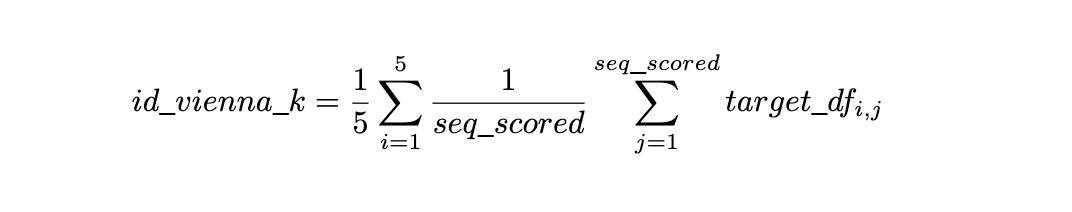

In [28]:
def average_and_combine(pub_df, priv_df):
  df_combined = pd.concat([priv_df, pub_df])
  df_combined.reset_index(drop=True, inplace=True)

  #calculate average degradation using the above formula
  final_df = df_combined.eval('avg_degradation = (1/5)*(reactivity + deg_Mg_pH10 + deg_pH10 + deg_Mg_50C + deg_50C)')
  reset_columns_seq = ['seq_id', 'package', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'avg_degradation']
  final_df = final_df[reset_columns_seq]
  return final_df

vienna_avg_pred_df = average_and_combine(vienna_pred_pub_df, vienna_pred_priv_df)
contrafold_avg_pred_df = average_and_combine(contrafold_pred_pub_df, contrafold_pred_priv_df)
rnastructure_avg_pred_df = average_and_combine(rnastructure_pred_pub_df, rnastructure_pred_priv_df)